In [80]:
from pathlib import Path

from math import sqrt

import numpy as np
import pandas as pd

from numba import njit

from matplotlib import pyplot as plt

### Load reference data

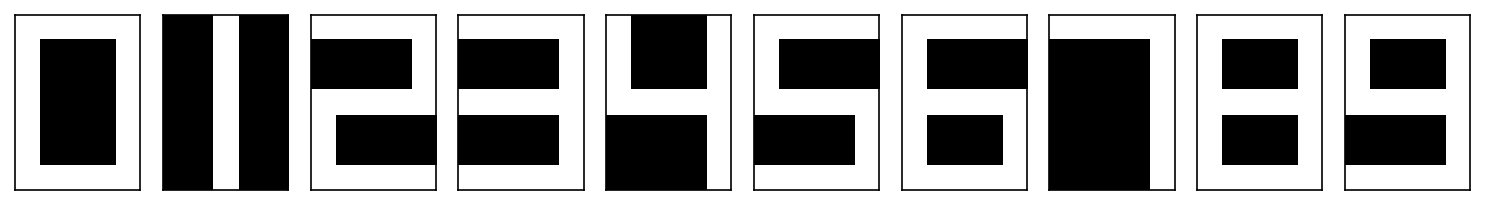

In [81]:
fig, axes = plt.subplots(nrows=1, ncols=10)

fig.set_dpi(150)
fig.set_figwidth(10)
fig.set_figheight(5)

img_shape = (7, 5)
img_size = 35

data_path = Path(r'D:/Development/Data/datasets/txt/numbers_7x5.txt')
data_mtrx = np.loadtxt(data_path)

for n, ax in zip(data_mtrx, axes.ravel()):
    ax.imshow(n.reshape(img_shape), cmap='binary_r')
    ax.set_xticks([])
    ax.set_yticks([])

plt.tight_layout()
plt.show()

### Generate dataset

In [82]:
cells_columns = [f'c{n}' for n in range(img_size)]
classes = ['zero', 'one', 'two', 'three', 'four', 'five', 'six', 'seven', 'eight', 'nine']

df = pd.DataFrame(columns=cells_columns + ['class'])

for i in range(10):
    new_row = dict(zip(cells_columns, data_mtrx[i]))
    new_row['class'] = classes[i]

    df.loc[df.index.size] = new_row

    for j in range(9):
        noised_num = data_mtrx[i] + np.random.uniform(0, 0.25, img_size)

        new_row = dict(zip(cells_columns, noised_num))
        new_row['class'] = classes[i]

        df.loc[df.index.size] = new_row

for name in df['class'].unique():
    df[f'{name}_label'] = df['class'].map(lambda x: 1 if x == name else 0)

### Split dataset to test and train

In [83]:
test_frac = 0.2

p = np.arange(10)

test_size = int(p.size * test_frac)
train_size = int(p.size * (1 - test_frac))

idx_test = np.ravel([(p[0:test_size] + i * 10) for i in range(10)])
idx_train = np.ravel([(p[test_size:p.size] + i * 10) for i in range(10)])

features_columns = cells_columns
label_columns = [f"{name}_label" for name in classes]

x_test = np.array(df.iloc[idx_test][features_columns]).astype(np.float64)
y_test = np.array(df.iloc[idx_test][label_columns]).astype(np.float64)

x_train = np.array(df.iloc[idx_train][features_columns]).astype(np.float64)
y_train = np.array(df.iloc[idx_train][label_columns]).astype(np.float64)

### Define functions

In [84]:
@njit(fastmath=True)
def norm(x: np.ndarray) -> float:
    return sqrt(np.sum(np.square(x)))


@njit(fastmath=True)
def cosim(a: np.ndarray, b: np.ndarray) -> float:
    return (a @ b) / (norm(a) * norm(b))


@njit(fastmath=True)
def mcosim(m: np.ndarray, x: np.ndarray) -> float:
    y = np.zeros(m.shape[0])
    x_norm = norm(x)
    
    for i in range(m.shape[0]):
        y[i] = (m[i] @ x) / (norm(m[i]) * x_norm)
        
    return y


@njit(fastmath=True)
def ReLU(x: np.ndarray) -> np.ndarray:
    return np.maximum(np.zeros(x.shape), x)


@njit(fastmath=True)
def dReLU(x: np.ndarray) -> np.ndarray:
    return 1 * (x > 0)


@njit(fastmath=True)
def softmax(x: np.ndarray) -> float:
    y = np.exp(x)
    return y / np.sum(y)

### Define model

In [154]:
@njit(fastmath=True)
def grads(x_batch: np.ndarray, y_batch: np.ndarray, W: np.ndarray, b: np.ndarray, Q: np.ndarray, c: np.ndarray, R: np.ndarray, d: np.ndarray) -> tuple[np.ndarray]:
    dW = np.zeros(W.shape)
    db = np.zeros(b.shape)

    dQ = np.zeros(Q.shape)
    dc = np.zeros(c.shape)

    dR = np.zeros(R.shape)
    dd = np.zeros(d.shape)

    for i in range(x_batch.shape[0]):
        y = softmax(W @ x_batch[i] + b)

        t = Q @ y + c
        dt = dReLU(t)
        t = ReLU(t)

        x_hat = R @ t + d
    
        dR += np.outer(2 * (x_hat - x_batch[i]), t)
        dd += 2 * (x_hat - x_batch[i])

        dQ += np.outer(2 * R.T @ (x - x_batch[i]) * dt, y)
        dc += 2 * R.T @ (x_hat - x_batch[i]) * dt

        dW += np.outer(y - y_batch[i], x_batch[i])
        db += y - y_batch[i]

    return (dW, db, dQ, dc, dR, dd)


class Perceptron:
    def __init__(self, nIn: int, nOut: int, nH: int) -> None:
        self.nIn = nIn
        self.nOut = nOut
        self.nH = nH

        self.W: np.ndarray = np.random.uniform(-1, 1, (nOut, nIn))
        self.b: np.ndarray = np.zeros(nOut)

        self.Q: np.ndarray = np.random.uniform(-1, 1, (nH, nOut))
        self.c: np.ndarray = np.zeros(nH)

        self.R: np.ndarray = np.random.uniform(-1, 1, (nIn, nH))
        self.d: np.ndarray = np.zeros(nIn)


    def predict(self, x: np.ndarray, n_iter: int = 1) -> np.ndarray:
        y = None

        for i in range(n_iter):
            y = softmax(self.W @ x + self.b)
            t = ReLU(self.Q @ y + self.c)
            x = x + self.R @ t + self.d

        return y

    def loss(self, x_batch: np.ndarray, y_batch: np.ndarray) -> float:
        y_pred_batch = np.array([self.predict(x) for x in x_batch])
        h = np.sum(y_batch * y_pred_batch, axis=1)
        return 1 - np.mean(h)

    def train(self, x_train: np.ndarray, y_train: np.ndarray, lr, batch_size, max_epoch) -> None:
        n = x_train.shape[0]
        n_batches = n // batch_size

        for epoch in range(max_epoch):
            idxs = np.random.permutation(n)

            for i in range(n_batches):
                ibegin = i * batch_size
                iend = min((i + 1) * batch_size, n - 1)
                batch_idxs = idxs[ibegin:iend]

                dW, db, dQ, dc, dR, dd = grads(
                    x_train[batch_idxs],
                    y_train[batch_idxs],
                    self.W,
                    self.b,
                    self.Q,
                    self.c,
                    self.R,
                    self.d
                )

                self.W -= lr * dW
                self.b -= lr * db

                self.Q -= lr * dQ
                self.c -= lr * dc

                self.R -= lr * dR
                self.d -= lr * dd

### Create and train model

In [155]:
nIn = 35
nOut = 10
nH = 10

learning_rate = 1e-2
batch_size = 16
max_epoch = 256

model = Perceptron(nIn, nOut, nH)

print('untrained loss: ', model.loss(x_test, y_test).round(4))

model.train(x_train, y_train, learning_rate, batch_size, max_epoch)

print('trained loss: ', model.loss(x_test, y_test).round(4))

n_true_pos = 0

for x, y in zip(x_test, y_test):
    ypred = model.predict(x)
    n_true_pos += 1 if np.argmax(ypred) == np.argmax(y) else 0

accuracy = round(n_true_pos / x_test.shape[0] * 100, 2)
print(f"test set accuracy: {accuracy}%")

untrained loss:  0.8991
trained loss:  0.0452
test set accuracy: 100.0%


### Test model on big number of noised samples

In [144]:
n_samples = 10000
noise_size = 0.5

n_true_pos = 0

for i in range(n_samples):
    j = i % 10
    x = data_mtrx[j] + np.random.uniform(0, noise_size, img_size)
    ypred = model.predict(x)
    n_true_pos += 1 if j == np.argmax(ypred) else 0

accuracy = round(n_true_pos / n_samples * 100, 2)
print(f"accuracy: {accuracy}% ({n_true_pos} of {n_samples})")

accuracy: 99.99% (9999 of 10000)


### Visualize model predictions

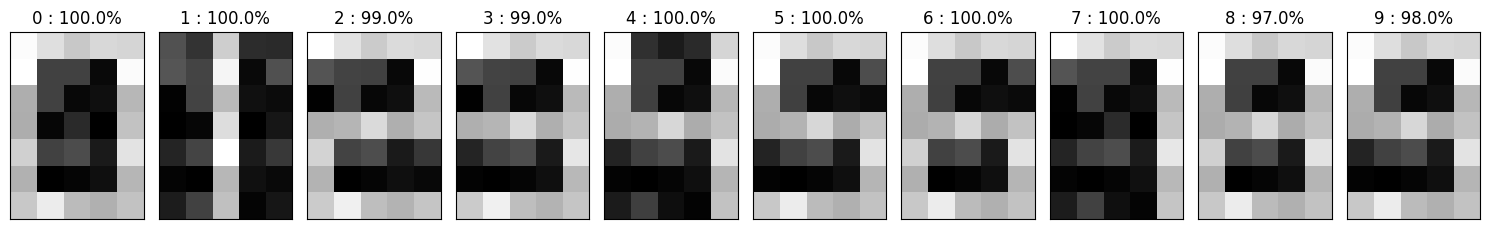

In [51]:
noise_size = 0.5
x_noised = data_mtrx + np.random.uniform(0, noise_size, img_size)

ypred = list([model.predict(xi) for xi in x_noised])

fig, axes = plt.subplots(nrows=1, ncols=10)

fig.set_dpi(100)
fig.set_figwidth(15)
fig.set_figheight(5)

for i, ax in enumerate(axes.ravel()):
    ax.imshow(x_noised[i].reshape(img_shape),  cmap='binary_r')
    j = np.argmax(ypred[i])

    ax.set_title(f"{j} : {(ypred[i][j] * 100).round()}%")
    ax.set_xticks([])
    ax.set_yticks([])

plt.tight_layout()
plt.show()

### Model's learned representations

In [11]:
# fig, axes = plt.subplots(nrows=1, ncols=model.nOut)
# fig.set_figwidth(15)
# fig.set_figheight(5)
# fig.set_dpi(100)

# for i in range(model.nOut):
#     img = axes[i].imshow(model.W[i].reshape(img_shape), cmap='binary_r')
#     axes[i].set_xticks([])
#     axes[i].set_yticks([])
#     axes[i].set_title(f'vector {i}')

# plt.tight_layout()
# plt.show()

[0.   0.8  0.01 0.   0.   0.02 0.03 0.   0.13 0.01]
[0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]


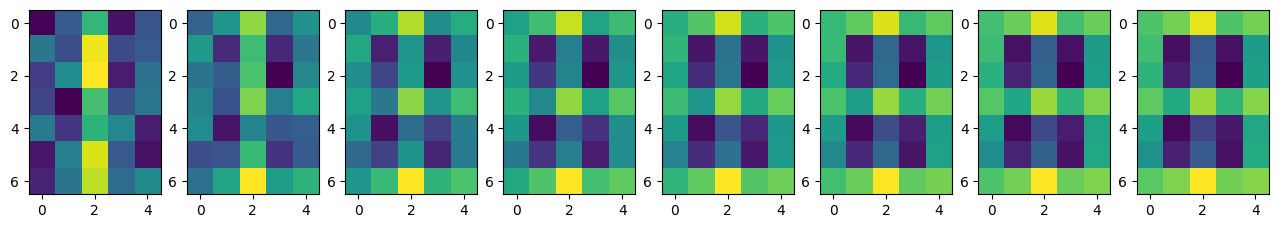

<Figure size 640x480 with 0 Axes>

In [157]:
x = data_mtrx[1] + np.random.uniform(0, 1, img_size)
y = softmax(model.W @ x + model.b)

print(np.round(y, 2))

X = [x.copy()]

for i in range(7):
    y = softmax(model.W @ x + model.b)
    t = ReLU(model.Q @ y + model.c)
    x = x + model.R @ t + model.d
    X.append(x.copy())

print(np.round(y, 2))

fig, axes = plt.subplots(nrows=1, ncols=8)
fig.set_figwidth(16)
fig.set_figheight(5)
fig.set_dpi(100)

for ax, xi in zip(axes, X):
    ax.imshow(xi.reshape((7, 5)))

plt.show()
plt.tight_layout()

In [153]:
x = data_mtrx[1] + np.random.uniform(0, 1, img_size)

# print(np.round(x,3))

y = softmax(model.W @ x + model.b)

# print(np.round(y, 2))

t = model.Q @ y + model.c

print(np.round(t, 2))

t = ReLU(model.Q @ y + model.c)

print(np.round(t, 2))


x = model.R @ t + model.d

# print(np.round(x,3))

print(np.round(model.Q, 2))


[-36.5   -1.11  -0.1   -4.33 -18.14  -6.33  -3.16  -0.17  -0.24  -3.18]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[[-9.000e-02  7.000e-02 -5.000e-01 -3.600e-01  3.393e+01 -4.500e-01
  -3.100e-01 -8.300e-01 -6.700e-01  5.600e-01]
 [-6.500e-01 -3.300e-01  7.500e-01  7.900e-01  5.400e-01  2.400e-01
   4.800e-01 -9.000e-02  5.500e-01  2.400e-01]
 [ 4.200e-01  3.900e-01 -1.000e-01 -5.500e-01  1.200e-01 -3.800e-01
  -7.700e-01 -7.600e-01  4.700e-01  4.900e-01]
 [ 7.900e-01  1.869e+01  9.800e-01 -9.300e-01  1.000e+00 -6.500e-01
  -4.700e-01  9.900e-01 -9.100e-01 -1.700e-01]
 [-5.000e-01 -8.000e-02 -4.600e-01 -5.100e-01  2.700e-01 -3.900e-01
   2.581e+01 -8.400e-01  7.400e-01  7.800e-01]
 [-1.000e-01  3.431e+01  5.700e-01 -8.900e-01 -4.800e-01 -9.000e-01
   2.600e-01  1.100e-01  4.500e-01 -4.800e-01]
 [ 3.000e-02 -3.500e-01  2.600e-01  9.700e-01 -4.000e-01  4.300e-01
   1.600e-01  5.000e-02  4.200e-01  6.100e-01]
 [-6.200e-01  3.440e+00  5.400e-01  1.200e-01 -2.100e-01 -5.500e-01
  -3.300e-01 -4.700e-01